In [1]:
import os
import copy
import torch
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter

random_state = 42

In [2]:
def fix_random(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


fix_random(random_state)

## Device

In [3]:
# PyTorch Device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("Device: {}".format(device))

Device: cuda


## Data Loading


In [4]:
df = pd.read_csv("train.csv")
num_rows, num_cols = df.shape
print("Rows: ", num_rows)
print("Columns: ", num_cols)

Rows:  252175
Columns:  91


In [5]:
print("Null rows:", df.shape[0] - df.dropna().shape[0])
print("Duplicated rows:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

Null rows: 0
Duplicated rows: 52


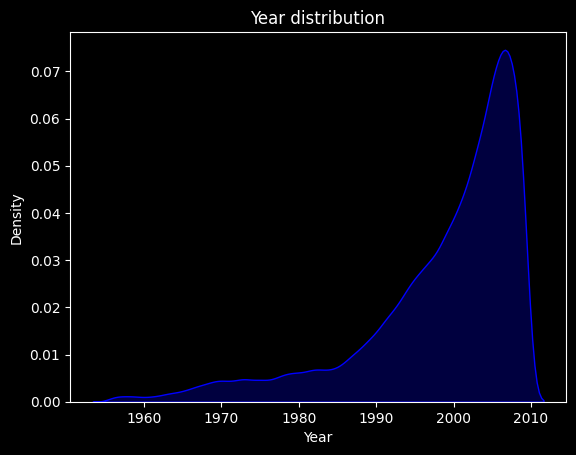

In [6]:
plt.title("Year distribution")
sns.kdeplot(data=df["Year"], fill=True, color="b")
plt.show()

### Train Test Split

In [7]:
# Separate indices in train/val/set
# "stratify=y" makes sure to keep the classes proportions on the dataset (useful on imbalanced classes)
# train, test = train_test_split(df, stratify=df["Year"], test_size=0.3, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["Year"]), df["Year"], stratify=df["Year"], test_size=0.3, random_state=random_state
)

In [8]:
from imblearn.under_sampling import RandomUnderSampler

# Instantiate the RandomUnderSampler
rus = RandomUnderSampler(random_state=random_state, sampling_strategy="majority")

# Fit the RandomUnderSampler
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

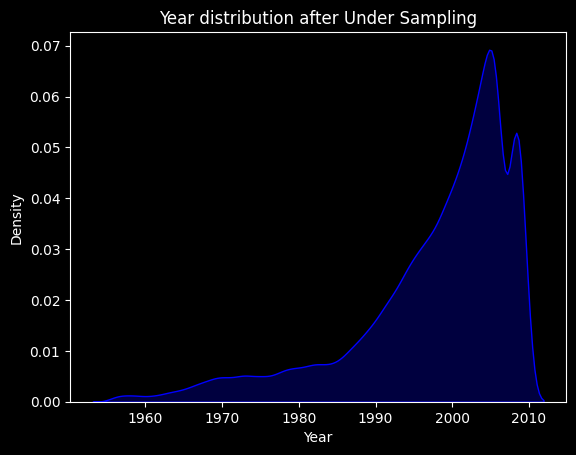

In [9]:
plt.title("Year distribution after Under Sampling")
sns.kdeplot(y_resampled, fill=True, color="b")
plt.show()

### Preprocessing 

In [10]:
from sklearn import preprocessing
from sklearn.covariance import OAS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import Pipeline

# pipeline = Pipeline(steps=[
#     ("min-max", preprocessing.MinMaxScaler()),
#     ("lmax", preprocessing.Normalizer(norm="max")),
#     ("lda", LinearDiscriminantAnalysis(solver="eigen", shrinkage=None, covariance_estimator=OAS()))
# ])

pipeline = Pipeline(
    [
        ("min-max", preprocessing.MinMaxScaler()),
        ("lda", LinearDiscriminantAnalysis(solver="eigen", covariance_estimator=OAS())),
        ("nys", Nystroem(random_state=random_state, n_jobs=-1, gamma=0.010, n_components=1000)),
    ]
)

# Fit the pipeline to the data
pipeline.fit(X_resampled, y_resampled)

# Transform the data using the pipeline
X_train_t = pipeline.transform(X_resampled)
X_test_t = pipeline.transform(X_test)

X_train_t = pd.DataFrame(X_train_t)
X_test_t = pd.DataFrame(X_test_t)

train_t = pd.DataFrame(X_train_t)
test_t = pd.DataFrame(X_test_t)

In [11]:
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [12]:
train_t["Year"] = y_train
test_t["Year"] = y_test

## Config


In [13]:
target = ["Year"]
continous_cols = list(train_t.columns)[:-1]

In [14]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models import TabNetModelConfig, TabTransformerConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig
from pytorch_tabular.models.common.heads import LinearHeadConfig

In [15]:
data_config = DataConfig(target=target, continuous_cols=continous_cols, num_workers=0)  ## su windows solo 0 funziona

optimizer_config = OptimizerConfig()

head_config = LinearHeadConfig(
    layers="",  # No additional layer in head, just a mapping layer to output_dim
    # dropout=0.1,
    initialization="kaiming",
).__dict__  # Convert to dict to pass to the model config (OmegaConf doesn't accept objects)

## Train

### TabNet

In [ ]:
learning_rates = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [128, 256]
#batch_sizes = [256, 512, 1024]

#virtual_batch_sizes = [128, 256]
n_epochs = [100, 200]
# Dimension of the prediction  layer
n_d = [16, 32]
#n_d = [16, 32]
#n_d = [8, 16, 32, 64]
# Dimension of the attention  layer
n_a = [16, 32]
#n_a = [8, 16, 32, 64]
# Number of successive steps in the network
#n_steps = [3, 5]
n_steps = [3, 5]

# Number of independent GLU layer in each GLU block
# n_indipendent = [2, 3]
# Coefficient for feature reusage in the masks. A value close to 1 will make mask selection least correlated between layers. Values range from 1.0 to 2.0.
gamma = [1.3, 1.5]

params = list(product(learning_rates, 
                      batch_sizes, 
                      #virtual_batch_sizes, 
                      n_epochs, 
                      n_d, 
                      n_a, 
                      n_steps, 
                      gamma))
comb = (
    len(learning_rates)
    * len(batch_sizes)
    #* len(virtual_batch_sizes)
    * len(n_epochs)
    * len(n_d)
    * len(n_a)
    * len(n_steps)
    * len(gamma)
)
print("Number of combinations: ", comb)

In [ ]:
best_mse = float("inf")
best_model = None
best_params = None
iter = 0
results = pd.DataFrame(columns=['loss', 'r2', 'learning_rate', 'batch_size', 'epochs', 'n_d', 'n_a', 'n_steps', 'gamma'])


for learning_rate, batch_size, epochs, n_d, n_a, n_steps, gamma in params:
    iter += 1
    print(f"\nIteration: {iter} of {comb}")
    print(
        f"Configuration: learning_rate={learning_rate}, batch_size={batch_size}, n_epochs={epochs}, n_d={n_d}, n_a={n_a}, n_steps={n_steps}, gamma={gamma}"
    )
    trainer_config = TrainerConfig(
        auto_lr_find=True,
        batch_size=batch_size,
        max_epochs=epochs,
        early_stopping_patience=20,
    )

    model_config = TabNetModelConfig(
        task="regression",
        learning_rate=learning_rate,
        head="LinearHead",  # Linear Head
        head_config=head_config,  # Linear Head Config
        #virtual_batch_size=virtual_batch_size,
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        # n_independent=n_independent
        )

    tabular_model = TabularModel(
        data_config=data_config,
        model_config=model_config,
        optimizer_config=optimizer_config,
        trainer_config=trainer_config,
    )

    tabular_model.fit(train=train_t)
    tabular_model.evaluate(test_t)

    y_pred= tabular_model.predict(X_test_t)
    mse= mean_squared_error(y_test, y_pred)
    r2= r2_score(y_test, y_pred)

    print("MSE: ", mse)
    print("R2: ", r2)

    if mse < best_mse:
        best_mse = mse
        best_model = copy.deepcopy(tabular_model)
        best_params = (learning_rate, batch_size, 
                       #virtual_batch_size, 
                       epochs, n_d, n_a, n_steps, gamma, #n_independent
                       )
        print("Best model updated")
    
    config = [mse, r2, learning_rate, batch_size, epochs, n_d, n_a, n_steps, gamma]
    results.loc[len(results)] = config

In [ ]:
results.sort_values(by='r2', ascending=False).head()

In [ ]:
results.sort_values(by='r2', ascending=False).to_csv('out_tabnet.csv')

### TabTransformer

In [19]:
# learning_rates = [0.001, 0.005, 0.01, 0.05]
# batch_sizes = [64, 128]
# n_epochs = [100, 200]
# virtual_batch_sizes = [128, 256]

virtual_batch_sizes = [64, 128]
batch_size = [512, 1024]
n_epochs = [50, 150]
learning_rates = [0.001, 0.005]

params = list(product(learning_rates, batch_size, n_epochs, virtual_batch_sizes))
comb = len(learning_rates) * len(batch_size) * len(n_epochs) * len(virtual_batch_sizes)
print("Number of combinations: ", comb)

Number of combinations:  16


In [20]:
best_mse_tt = float("inf")
best_model_tt = None
best_params_tt = None
iter = 0
results_tt = pd.DataFrame(columns=["loss", "r2", "learning_rate", "epochs", "batch_size", "virtual_batch_size"])

for learning_rate, batch_size, epochs, virtual_batch_size in params:
    iter += 1
    print(f"\nIteration: {iter} of {comb}")
    trainer_config = TrainerConfig(auto_lr_find=True,batch_size=batch_size, max_epochs=epochs, early_stopping_patience=20, load_best=True,)

    model_config = TabTransformerConfig(
        task="regression",
        learning_rate=learning_rate,
        head="LinearHead",  # Linear Head
        head_config=head_config,  # Linear Head Config
    )

    tabular_model = TabularModel(
        data_config=data_config,
        model_config=model_config,
        optimizer_config=optimizer_config,
        trainer_config=trainer_config,
    )

    tabular_model.fit(train=train_t)
    tabular_model.evaluate(test_t)

    y_pred = tabular_model.predict(X_test_t)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    config = [mse, r2, learning_rate, epochs, batch_size, virtual_batch_size]

    print("MSE: ", mse)
    print("R2: ", r2)

    if mse < best_mse_tt:
        best_mse_tt = mse
        best_model_tt = copy.deepcopy(tabular_model)
        best_params_tt = (learning_rate, batch_size, virtual_batch_size, epochs)
        print("Best model updated")

    results_tt.loc[len(results_tt)] = config


Iteration: 1 of 16


2024-01-30 16:47:19,391 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-01-30 16:47:19,482 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-01-30 16:47:21,837 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-01-30 16:47:26,012 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabTransformerModel

2024-01-30 16:47:26,116 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-01-30 16:47:26,535 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\evang.HOMEEVANGELISTI\git\Data-Analytics-Project\Train_Module\saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  273 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │  1.0 K │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 274 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 274 K                                                                                                
Total estimated model params size (MB): 1

Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

`Trainer.fit` stopped: `max_epochs=50` reached.


2024-01-30 16:56:01,071 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-01-30 16:56:01,074 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    113.63873291015625     │
│  test_mean_squared_error  │    113.63873291015625     │
└───────────────────────────┴───────────────────────────┘

MSE:  113.63874860436904
R2:  -0.031119922439569958
Best model updated

Iteration: 2 of 16


2024-01-30 16:56:09,476 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-01-30 16:56:09,600 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-01-30 16:56:11,910 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-01-30 16:56:15,970 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabTransformerModel

2024-01-30 16:56:16,071 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-01-30 16:56:16,096 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\evang.HOMEEVANGELISTI\git\Data-Analytics-Project\Train_Module\saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  273 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │  1.0 K │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 274 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 274 K                                                                                                
Total estimated model params size (MB): 1

Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

`Trainer.fit` stopped: `max_epochs=50` reached.


2024-01-30 17:04:45,074 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-01-30 17:04:45,077 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    113.63873291015625     │
│  test_mean_squared_error  │    113.63873291015625     │
└───────────────────────────┴───────────────────────────┘

MSE:  113.63874860436904
R2:  -0.031119922439569958

Iteration: 3 of 16


2024-01-30 17:04:52,533 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-01-30 17:04:52,651 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-01-30 17:04:54,878 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-01-30 17:04:58,906 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabTransformerModel

2024-01-30 17:04:59,012 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-01-30 17:04:59,036 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\evang.HOMEEVANGELISTI\git\Data-Analytics-Project\Train_Module\saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  273 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │  1.0 K │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 274 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 274 K                                                                                                
Total estimated model params size (MB): 1

Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

2024-01-30 17:28:41,952 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-01-30 17:28:41,955 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    110.72586822509766     │
│  test_mean_squared_error  │    110.72586822509766     │
└───────────────────────────┴───────────────────────────┘

MSE:  110.72585320448623
R2:  -0.004689285744876148
Best model updated

Iteration: 4 of 16


2024-01-30 17:28:50,656 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-01-30 17:28:50,878 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-01-30 17:28:53,234 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-01-30 17:28:57,485 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabTransformerModel

2024-01-30 17:28:57,586 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-01-30 17:28:57,613 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\evang.HOMEEVANGELISTI\git\Data-Analytics-Project\Train_Module\saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  273 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │  1.0 K │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 274 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 274 K                                                                                                
Total estimated model params size (MB): 1

Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

2024-01-30 17:52:44,936 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-01-30 17:52:44,939 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    110.72586822509766     │
│  test_mean_squared_error  │    110.72586822509766     │
└───────────────────────────┴───────────────────────────┘

MSE:  110.72585320448623
R2:  -0.004689285744876148

Iteration: 5 of 16


2024-01-30 17:52:52,708 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-01-30 17:52:52,812 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-01-30 17:52:55,081 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-01-30 17:52:59,016 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabTransformerModel

2024-01-30 17:52:59,114 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-01-30 17:52:59,138 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\evang.HOMEEVANGELISTI\git\Data-Analytics-Project\Train_Module\saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  273 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │  1.0 K │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 274 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 274 K                                                                                                
Total estimated model params size (MB): 1

Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

2024-01-30 17:58:49,829 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-01-30 17:58:49,833 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │      131.29443359375      │
│  test_mean_squared_error  │      131.29443359375      │
└───────────────────────────┴───────────────────────────┘

MSE:  131.2944003673042
R2:  -0.19132138980875446

Iteration: 6 of 16


2024-01-30 17:58:56,844 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-01-30 17:58:56,972 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-01-30 17:58:59,187 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-01-30 17:59:03,158 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabTransformerModel

2024-01-30 17:59:03,262 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-01-30 17:59:03,286 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\evang.HOMEEVANGELISTI\git\Data-Analytics-Project\Train_Module\saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  273 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │  1.0 K │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 274 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 274 K                                                                                                
Total estimated model params size (MB): 1

Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

2024-01-30 18:04:53,800 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-01-30 18:04:53,803 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │      131.29443359375      │
│  test_mean_squared_error  │      131.29443359375      │
└───────────────────────────┴───────────────────────────┘

MSE:  131.2944003673042
R2:  -0.19132138980875446

Iteration: 7 of 16


2024-01-30 18:05:00,754 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-01-30 18:05:00,863 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-01-30 18:05:03,073 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-01-30 18:05:07,027 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabTransformerModel

2024-01-30 18:05:07,127 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-01-30 18:05:07,153 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\evang.HOMEEVANGELISTI\git\Data-Analytics-Project\Train_Module\saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  273 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │  1.0 K │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 274 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 274 K                                                                                                
Total estimated model params size (MB): 1

Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

2024-01-30 18:10:58,320 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-01-30 18:10:58,323 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │      131.29443359375      │
│  test_mean_squared_error  │      131.29443359375      │
└───────────────────────────┴───────────────────────────┘

MSE:  131.2944003673042
R2:  -0.19132138980875446

Iteration: 8 of 16


2024-01-30 18:11:05,386 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-01-30 18:11:05,516 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-01-30 18:11:07,773 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-01-30 18:11:11,697 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabTransformerModel

2024-01-30 18:11:11,798 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-01-30 18:11:11,826 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\evang.HOMEEVANGELISTI\git\Data-Analytics-Project\Train_Module\saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  273 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │  1.0 K │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 274 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 274 K                                                                                                
Total estimated model params size (MB): 1

Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

2024-01-30 18:16:55,771 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-01-30 18:16:55,774 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │      131.29443359375      │
│  test_mean_squared_error  │      131.29443359375      │
└───────────────────────────┴───────────────────────────┘

MSE:  131.2944003673042
R2:  -0.19132138980875446

Iteration: 9 of 16


2024-01-30 18:17:02,806 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-01-30 18:17:02,913 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-01-30 18:17:05,082 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-01-30 18:17:09,019 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabTransformerModel

2024-01-30 18:17:09,116 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-01-30 18:17:09,140 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\evang.HOMEEVANGELISTI\git\Data-Analytics-Project\Train_Module\saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  273 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │  1.0 K │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 274 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 274 K                                                                                                
Total estimated model params size (MB): 1

Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

`Trainer.fit` stopped: `max_epochs=50` reached.


2024-01-30 18:25:29,608 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-01-30 18:25:29,611 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     112.5121841430664     │
│  test_mean_squared_error  │     112.5121841430664     │
└───────────────────────────┴───────────────────────────┘

MSE:  112.5121752068601
R2:  -0.020897772965660533

Iteration: 10 of 16


2024-01-30 18:25:37,169 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-01-30 18:25:37,302 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-01-30 18:25:39,501 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-01-30 18:25:43,428 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabTransformerModel

2024-01-30 18:25:43,524 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-01-30 18:25:43,549 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\evang.HOMEEVANGELISTI\git\Data-Analytics-Project\Train_Module\saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  273 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │  1.0 K │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 274 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 274 K                                                                                                
Total estimated model params size (MB): 1

Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

`Trainer.fit` stopped: `max_epochs=50` reached.


2024-01-30 18:34:23,217 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-01-30 18:34:23,219 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     112.5121841430664     │
│  test_mean_squared_error  │     112.5121841430664     │
└───────────────────────────┴───────────────────────────┘

MSE:  112.5121752068601
R2:  -0.020897772965660533

Iteration: 11 of 16


2024-01-30 18:34:30,933 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-01-30 18:34:31,075 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-01-30 18:34:33,350 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-01-30 18:34:37,338 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabTransformerModel

2024-01-30 18:34:37,443 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-01-30 18:34:37,469 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\evang.HOMEEVANGELISTI\git\Data-Analytics-Project\Train_Module\saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  273 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │  1.0 K │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 274 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 274 K                                                                                                
Total estimated model params size (MB): 1

Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

2024-01-30 18:47:47,759 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-01-30 18:47:47,763 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    112.49600219726562     │
│  test_mean_squared_error  │    112.49600219726562     │
└───────────────────────────┴───────────────────────────┘

MSE:  112.49600422492148
R2:  -0.02075104289473728

Iteration: 12 of 16


2024-01-30 18:47:55,514 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-01-30 18:47:55,631 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-01-30 18:47:57,967 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-01-30 18:48:01,942 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabTransformerModel

2024-01-30 18:48:02,039 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-01-30 18:48:02,063 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\evang.HOMEEVANGELISTI\git\Data-Analytics-Project\Train_Module\saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  273 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │  1.0 K │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 274 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 274 K                                                                                                
Total estimated model params size (MB): 1

Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

2024-01-30 19:01:29,647 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-01-30 19:01:29,650 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    112.49600219726562     │
│  test_mean_squared_error  │    112.49600219726562     │
└───────────────────────────┴───────────────────────────┘

MSE:  112.49600422492148
R2:  -0.02075104289473728

Iteration: 13 of 16


2024-01-30 19:01:37,461 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-01-30 19:01:37,564 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-01-30 19:01:39,866 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-01-30 19:01:43,873 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabTransformerModel

2024-01-30 19:01:43,975 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-01-30 19:01:44,001 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\evang.HOMEEVANGELISTI\git\Data-Analytics-Project\Train_Module\saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  273 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │  1.0 K │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 274 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 274 K                                                                                                
Total estimated model params size (MB): 1

Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

`Trainer.fit` stopped: `max_epochs=50` reached.


2024-01-30 19:08:26,194 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-01-30 19:08:26,196 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     112.8958969116211     │
│  test_mean_squared_error  │     112.8958969116211     │
└───────────────────────────┴───────────────────────────┘

MSE:  112.89589859362367
R2:  -0.02437955038451789

Iteration: 14 of 16


2024-01-30 19:08:33,682 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-01-30 19:08:33,834 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-01-30 19:08:36,146 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-01-30 19:08:40,200 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabTransformerModel

2024-01-30 19:08:40,311 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-01-30 19:08:40,341 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\evang.HOMEEVANGELISTI\git\Data-Analytics-Project\Train_Module\saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  273 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │  1.0 K │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 274 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 274 K                                                                                                
Total estimated model params size (MB): 1

Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

`Trainer.fit` stopped: `max_epochs=50` reached.


2024-01-30 19:15:21,747 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-01-30 19:15:21,750 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     112.8958969116211     │
│  test_mean_squared_error  │     112.8958969116211     │
└───────────────────────────┴───────────────────────────┘

MSE:  112.89589859362367
R2:  -0.02437955038451789

Iteration: 15 of 16


2024-01-30 19:15:28,915 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-01-30 19:15:29,071 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-01-30 19:15:31,330 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-01-30 19:15:35,383 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabTransformerModel

2024-01-30 19:15:35,485 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-01-30 19:15:35,511 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\evang.HOMEEVANGELISTI\git\Data-Analytics-Project\Train_Module\saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  273 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │  1.0 K │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 274 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 274 K                                                                                                
Total estimated model params size (MB): 1

Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

2024-01-30 19:24:26,151 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-01-30 19:24:26,153 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     112.8958969116211     │
│  test_mean_squared_error  │     112.8958969116211     │
└───────────────────────────┴───────────────────────────┘

MSE:  112.89589859362367
R2:  -0.02437955038451789

Iteration: 16 of 16


2024-01-30 19:24:33,582 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-01-30 19:24:33,721 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-01-30 19:24:35,911 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-01-30 19:24:39,920 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabTransformerModel

2024-01-30 19:24:40,022 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-01-30 19:24:40,047 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\evang.HOMEEVANGELISTI\git\Data-Analytics-Project\Train_Module\saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  273 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │  1.0 K │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 274 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 274 K                                                                                                
Total estimated model params size (MB): 1

Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\
connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve 
performance.

2024-01-30 19:33:17,809 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-01-30 19:33:17,809 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\evang.HOMEEVANGELISTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     112.8958969116211     │
│  test_mean_squared_error  │     112.8958969116211     │
└───────────────────────────┴───────────────────────────┘

MSE:  112.89589859362367
R2:  -0.02437955038451789


In [21]:
results_tt.sort_values(by="r2", ascending=False).head()

,loss,r2,learning_rate,epochs,batch_size,virtual_batch_size
2,110.725853,-0.004689,0.001,150.0,512.0,64.0
3,110.725853,-0.004689,0.001,150.0,512.0,128.0
10,112.496004,-0.020751,0.005,150.0,512.0,64.0
11,112.496004,-0.020751,0.005,150.0,512.0,128.0
8,112.512175,-0.020898,0.005,50.0,512.0,64.0


In [22]:
results_tt.sort_values(by="r2", ascending=False).to_csv("out_tab_transformers3.csv")